# Exploratory Data Analysis (EDA)

This notebook contains the EDA performed for obtaining insights from the ChemSoR database as prior step to build ML models.

In [1]:
# Importing libraries
%matplotlib inline
import pandas as pd
import os
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

## 1. Opening the database

In [2]:
def create_engine_instance():
    '''
    Function to create an SQL engine
    '''
    
    # ChemSoR_database.db path
    chemsor_path = os.path.join(os. getcwd(),
                                os.pardir,
                                'data',
                                'transformed',
                                'ChemSoR_database.db')
    
    # URL string
    url = f'sqlite:///{chemsor_path}'

    # Creating engine
    engine = create_engine(url)

    return engine

In [3]:
def opening_dataset():
    '''
    Function to open dataset based on sql query
    '''

    # Creating connection
    engine = create_engine_instance()
    
    # Query for only selecting the desired columns
    sql_query = '''
                SELECT r.reporting_year,
                       r.naics_code,
                       sra.source_reduction_code,
                       sra.source_reduction_description,
                       re.reduction_code,
                       re.description_code,
                       c.chemical_name,
                       c.cas_number,
                       c.caac_ind,
                       c.carc_ind,
                       c.pfas_ind,
                       c.metal_ind,
                       c.smiles
                FROM record AS r
                INNER JOIN source_reduction_activity AS sra
                ON r.source_reduction_activity_id = sra.source_reduction_activity_id
                INNER JOIN reduction AS re
                ON r.reduction_id = re.reduction_id
                INNER JOIN chemical AS c
                ON r.chemical_id
                '''
    
    # Fetching the information
    df = pd.read_sql_query(sql_query, engine)
    
    return df

In [4]:
df = opening_dataset()

In [5]:
df.drop_duplicates(keep='first', inplace=True)

## 2. General dataset analysis

In [6]:
df.head()

,reporting_year,naics_code,source_reduction_code,source_reduction_description,reduction_code,description_code,chemical_name,cas_number,caac_ind,carc_ind,pfas_ind,metal_ind,smiles
0,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Formaldehyde,50-00-0,YES,YES,NO,NO,C=O
1,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Nitroglycerin,55-63-0,NO,NO,NO,NO,C(C(CO[N+](=O)[O-])O[N+](=O)[O-])O[N+](=O)[O-]
2,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Phenytoin,57-41-0,NO,YES,NO,NO,C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3
3,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Aniline,62-53-3,YES,NO,NO,NO,C1=CC=C(C=C1)N
4,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Dichlorvos,62-73-7,YES,YES,NO,NO,COP(=O)(OC)OC=C(Cl)Cl


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 980000 entries, 0 to 1302199
Data columns (total 13 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   reporting_year                980000 non-null  int64 
 1   naics_code                    980000 non-null  int64 
 2   source_reduction_code         980000 non-null  object
 3   source_reduction_description  980000 non-null  object
 4   reduction_code                980000 non-null  object
 5   description_code              980000 non-null  object
 6   chemical_name                 980000 non-null  object
 7   cas_number                    970200 non-null  object
 8   caac_ind                      980000 non-null  object
 9   carc_ind                      980000 non-null  object
 10  pfas_ind                      980000 non-null  object
 11  metal_ind                     980000 non-null  object
 12  smiles                        965300 non-null  object
dty

In [8]:
df = df[pd.notnull(df.smiles)]

In [9]:
df.reset_index(drop=True, inplace=True)

In [10]:
df.reporting_year.unique()

array([2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

During the ETL pipeline, a record was considered if it contains the needed fields useful for building ML models. As shown the above cell, information before reporing year 2014 was dropped. According to the information for the [TRI 2a File](https://www.epa.gov/system/files/documents/2021-08/file_type_2a_0.pdf), the program stated collecting information about reduction estimation since 2014. Due to the above, the available data are from reporting year 2014 to 2020 (last publicly-available TRI report).  

## 3. Individual feature analysis 

### 3.1. Chemicals

Let's start analyzing how many chemicals there are in the dataset after ETL

In [11]:
df_chemicals = df.iloc[:, 6:].drop_duplicates(keep='first').reset_index(drop=True)

In [12]:
number_of_unique_chemicals = df_chemicals.shape[0]
number_of_unique_chemicals

197

Let's check how many of those chemicals belongs to each of the classification provided by the TRI program, i.e., Clean Air Act (caac_ind), Carcinogen (carc_ind), metal (metal_ind), and Per- and polyfluoroalkyl substances (pfas_ind)

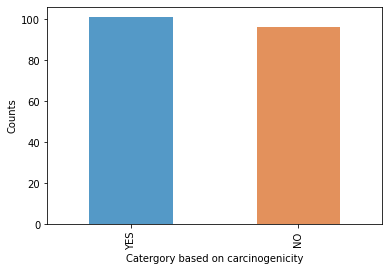

In [13]:
df_chemicals.caac_ind.value_counts().plot(kind='bar', color=['#2980B9', '#DC7633'], alpha=0.8)
plt.ylabel('Counts')
plt.xlabel('Catergory based on carcinogenicity')
plt.show()

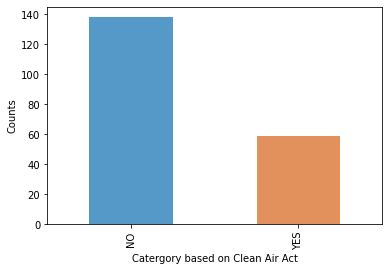

In [14]:
df_chemicals.carc_ind.value_counts().plot(kind='bar', color=['#2980B9', '#DC7633'], alpha=0.8)
plt.ylabel('Counts')
plt.xlabel('Catergory based on Clean Air Act')
plt.show()

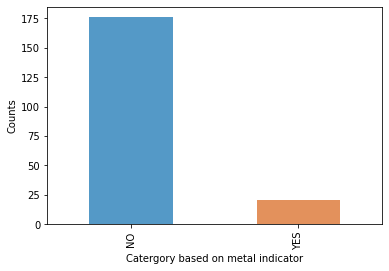

In [15]:
df_chemicals.metal_ind.value_counts().plot(kind='bar', color=['#2980B9', '#DC7633'], alpha=0.8)
plt.ylabel('Counts')
plt.xlabel('Catergory based on metal indicator')
plt.show()

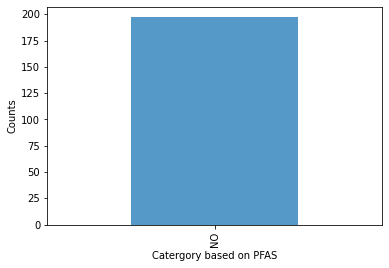

In [16]:
df_chemicals.pfas_ind.value_counts().plot(kind='bar', color=['#2980B9', '#DC7633'], alpha=0.8)
plt.ylabel('Counts')
plt.xlabel('Catergory based on PFAS')
plt.show()

As depicted above, the dataset contains only 197 out of around 700 chemicals subject to the TRI program. The following conclusions for the applicability domain of the model are obtained:

1. The dataset may not be useful for predicting source reduction activities for PFAS chemicals (TRI program started requering information for PFAS since 2020, see [link](https://www.epa.gov/toxics-release-inventory-tri-program/addition-certain-pfas-tri-national-defense-authorization-act)). Nonetheless, some PFAS chemicals may be represented if their chemical descriptors are similar to that for the chemicals available in the dataset.
2. Metallic compounds are poorly represented by the dataset.
3. Around 60 out of the 200 chemicals are subject by the Clean Air Act.
4. Carcinogenic chemicals are in a similar proportion than the non carcinogenic ones.

### 3.2. Industry sectors

Let's analyze the scenario for the industry sectors present in the dataset

In [17]:
df_sectors = df['naics_code'].drop_duplicates(keep='first').reset_index(drop=True)
number_of_unique_sectors = df_sectors.shape[0]
number_of_unique_sectors

320

In [18]:
naics_2_sectors = df_sectors.astype('str').str[0:2].unique().tolist()
naics_2_sectors.sort()
naics_2_sectors

['11',
 '21',
 '22',
 '31',
 '32',
 '33',
 '42',
 '49',
 '51',
 '54',
 '56',
 '61',
 '62',
 '81',
 '92']

In [19]:
len(naics_2_sectors)

15

Using the 6-digit NAICS codes, the dataset contains 320 sector. Nonetheless, if one-hot encoding is applied on this feature, it could increase drastically the dimensionality of the dataset, which is undesirable. Now, if only the 2-digit NAICS codes are used (the less specific classification), the dataset would offer an applicability domain for only 15 sectors:

- 11: Agriculture, Forestry, Fishing and Hunting (not covered in economic census)
- 21: Mining, Quarrying, and Oil and Gas Extraction
- 22: Utilities
- 31-33: Manufacturing
- 42: Wholesale Trade
- 49: Transportation and Warehousing
- 51: Information
- 54: Professional, Scientific, and Technical Services
- 56: Administrative and Support and Waste Management and Remediation Services
- 61: Educational Services
- 62: Health Care and Social Assistance
- 81: Other Services (except Public Administration)
- 92: Public Administration (not covered in economic census)

Thus, the applicability domain of the dataset contains 15 out of the 20 sectors in the NAICS classification (2-digit codes)

See [NAICS Structure](https://www.census.gov/programs-surveys/economic-census/guidance/understanding-naics.html)

Let's include the 2-digit NAICS code sector in the dataset for a further modeling

In [6]:
naics_dict = {
    '11': 'Agriculture, Forestry, Fishing and Hunting (not covered in economic census)',
    '21': 'Mining, Quarrying, and Oil and Gas Extraction',
    '22': 'Utilities',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale Trade',
    '49': 'Transportation and Warehousing',
    '51': 'Information',
    '54': 'Professional, Scientific, and Technical Services',
    '56': 'Administrative and Support and Waste Management and Remediation Services',
    '61': 'Educational Services',
    '62': 'Health Care and Social Assistance',
    '81': 'Other Services (except Public Administration)',
    '92': 'Public Administration (not covered in economic census)',
}

In [7]:
df['2_digit_naics'] = df.naics_code.astype('str').str[0:2].apply(lambda x: naics_dict[x])

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965300 entries, 0 to 965299
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   reporting_year                965300 non-null  int64 
 1   naics_code                    965300 non-null  int64 
 2   source_reduction_code         965300 non-null  object
 3   source_reduction_description  965300 non-null  object
 4   reduction_code                965300 non-null  object
 5   description_code              965300 non-null  object
 6   chemical_name                 965300 non-null  object
 7   cas_number                    965300 non-null  object
 8   caac_ind                      965300 non-null  object
 9   carc_ind                      965300 non-null  object
 10  pfas_ind                      965300 non-null  object
 11  metal_ind                     965300 non-null  object
 12  smiles                        965300 non-null  object
 13 

### 3.3. Source reduction activites

Now, let's check what happens with the dataset regarding the source reduction activites.

In [23]:
df[['reduction_code', 'description_code']].drop_duplicates(keep='first')

,reduction_code,description_code
0,R5,"greater than or equal 5%, but less than to 15%"
394,R2,"greater than or equal to 50%, but less than 100%"
788,R6,"greater than 0%, but less than 5%"
1576,R3,"greater than or equal to 25%, but less than 50%"
4925,R1,100% (elimination of the chemical)
7289,R4,"greater than or equal 15%, but less than to 25%"


As shown above, the dataset contains the 6 reduction codes. This reduction codes are ordinal. Thus, this feature could be encoded as ordinal. 

In [24]:
df[['source_reduction_code', 'source_reduction_description']].drop_duplicates(keep='first')

,source_reduction_code,source_reduction_description
0,W19,Other changes in operating practices
197,W36,Implemented inspection or monitoring program o...
394,W50,Optimized reaction conditions or otherwise inc...
591,W58,Other process modifications
985,W13,"Improved maintenance scheduling, recordkeeping..."
1379,W42,Substituted raw materials
2561,W32,"Improved procedures for loading, unloading, an..."
2758,W33,Installed overflow alarms or automatic shutoff...
2955,W39,Other spill or leak prevention
4334,W14,Changed production schedule to minimize equipm...


In [25]:
df[['source_reduction_code', 'source_reduction_description']].drop_duplicates(keep='first').shape[0]

49

As shown above, there are 49 source reduction activities, which means that the ML model would classify among 49 potential categories. This task could be complicated for the model considering that the dataset has 980,000 different samples. As an alternative, the source reduction activity categories belong to a more general categorization provided by the TRI program that contains only 8 categories (see [link](https://ordspub.epa.gov/ords/guideme_ext/guideme_ext/guideme/file/rfi_ry18.pdf)):

1. Good Operating Practices (W13, W14, W15, and W19) 
2. Inventory Control (W21, W22, W23, W24, W25, and W29)
3. Spill and Leak Prevention (W31, W32, W33, W35, W36, and W39)
4. Raw Material Modifications (W41, W42, W43, and W49)
5. Process Modifications (W50, W51, W52, W53, W54, W55, W56, W57, and W58)
6. Cleaning and Degreasing (W59, W60, W61, W63, W64, W65, W66, W67, W68, and W71)
7. Surface Preparation and Finishing (W72, W73, W74, W75, and W78)
8. Product Modifications (W81, W82, W83, W84, and W89)


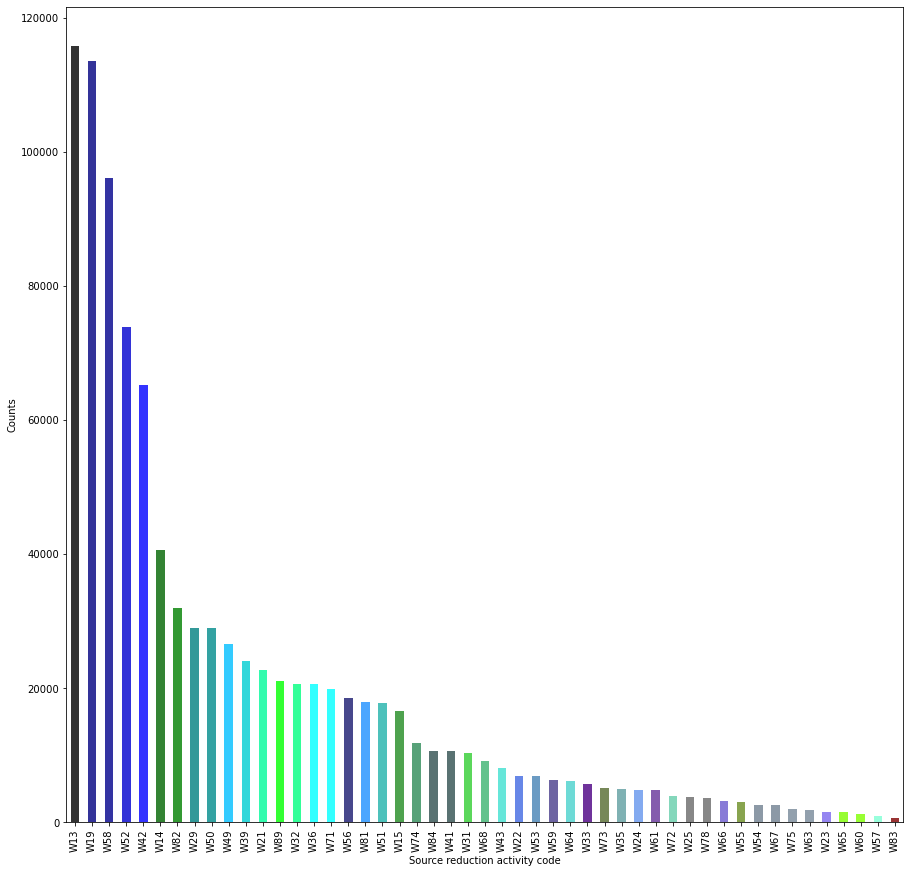

In [26]:
colors = list(mcolors.CSS4_COLORS.values())
colors.sort()
df['source_reduction_code'].value_counts().plot(kind='bar',
                                                alpha=0.8,
                                                figsize=(15, 15),
                                                color=colors[0:49])
plt.ylabel('Counts')
plt.xlabel('Source reduction activity code')
plt.show()

The figure above shows that for the 49 categories representing source reduction activities, the data set is very unbalanced. One option is to remove categories that appear few times in the data set. Another option is to use data augmentation techniques such as random oversampling to balance the data set.

In [8]:
mapping_dict = {
    'W13': 'Good Operating Practices',
    'W14': 'Good Operating Practices',
    'W15': 'Good Operating Practices',
    'W19': 'Good Operating Practices',
    'W21': 'Inventory Control',
    'W22': 'Inventory Control',
    'W23': 'Inventory Control',
    'W24': 'Inventory Control',
    'W25': 'Inventory Control',
    'W29': 'Inventory Control',
    'W31': 'Spill and Leak Prevention',
    'W32': 'Spill and Leak Prevention',
    'W33': 'Spill and Leak Prevention',
    'W35': 'Spill and Leak Prevention',
    'W36': 'Spill and Leak Prevention',
    'W39': 'Spill and Leak Prevention',
    'W41': 'Raw Material Modifications',
    'W42': 'Raw Material Modifications',
    'W43': 'Raw Material Modifications',
    'W49': 'Raw Material Modifications',
    'W50': 'Process Modifications',
    'W51': 'Process Modifications',
    'W52': 'Process Modifications',
    'W53': 'Process Modifications',
    'W54': 'Process Modifications',
    'W55': 'Process Modifications',
    'W56': 'Process Modifications',
    'W57': 'Process Modifications',
    'W58': 'Process Modifications',
    'W59': 'Cleaning and Degreasing',
    'W60': 'Cleaning and Degreasing',
    'W61': 'Cleaning and Degreasing',
    'W63': 'Cleaning and Degreasing',
    'W64': 'Cleaning and Degreasing',
    'W65': 'Cleaning and Degreasing',
    'W66': 'Cleaning and Degreasing',
    'W67': 'Cleaning and Degreasing',
    'W68': 'Cleaning and Degreasing',
    'W71': 'Cleaning and Degreasing',
    'W72': 'Surface Preparation and Finishing',
    'W73': 'Surface Preparation and Finishing',
    'W74': 'Surface Preparation and Finishing',
    'W75': 'Surface Preparation and Finishing',
    'W78': 'Surface Preparation and Finishing',
    'W81': 'Product Modifications',
    'W82': 'Product Modifications',
    'W83': 'Product Modifications',
    'W84': 'Product Modifications',
    'W89': 'Product Modifications'
}

In [28]:
len(mapping_dict.keys())

49

In [9]:
df['source_reduction_general_category'] = df['source_reduction_code'].map(mapping_dict)

In [30]:
df.head()

,reporting_year,naics_code,source_reduction_code,source_reduction_description,reduction_code,description_code,chemical_name,cas_number,caac_ind,carc_ind,pfas_ind,metal_ind,smiles,2_digit_naics,source_reduction_general_category
0,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Formaldehyde,50-00-0,YES,YES,NO,NO,C=O,"Mining, Quarrying, and Oil and Gas Extraction",Good Operating Practices
1,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Nitroglycerin,55-63-0,NO,NO,NO,NO,C(C(CO[N+](=O)[O-])O[N+](=O)[O-])O[N+](=O)[O-],"Mining, Quarrying, and Oil and Gas Extraction",Good Operating Practices
2,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Phenytoin,57-41-0,NO,YES,NO,NO,C1=CC=C(C=C1)C2(C(=O)NC(=O)N2)C3=CC=CC=C3,"Mining, Quarrying, and Oil and Gas Extraction",Good Operating Practices
3,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Aniline,62-53-3,YES,NO,NO,NO,C1=CC=C(C=C1)N,"Mining, Quarrying, and Oil and Gas Extraction",Good Operating Practices
4,2014,212111,W19,Other changes in operating practices,R5,"greater than or equal 5%, but less than to 15%",Dichlorvos,62-73-7,YES,YES,NO,NO,COP(=O)(OC)OC=C(Cl)Cl,"Mining, Quarrying, and Oil and Gas Extraction",Good Operating Practices


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 965300 entries, 0 to 965299
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   reporting_year                     965300 non-null  int64 
 1   naics_code                         965300 non-null  int64 
 2   source_reduction_code              965300 non-null  object
 3   source_reduction_description       965300 non-null  object
 4   reduction_code                     965300 non-null  object
 5   description_code                   965300 non-null  object
 6   chemical_name                      965300 non-null  object
 7   cas_number                         965300 non-null  object
 8   caac_ind                           965300 non-null  object
 9   carc_ind                           965300 non-null  object
 10  pfas_ind                           965300 non-null  object
 11  metal_ind                          965300 non-null  

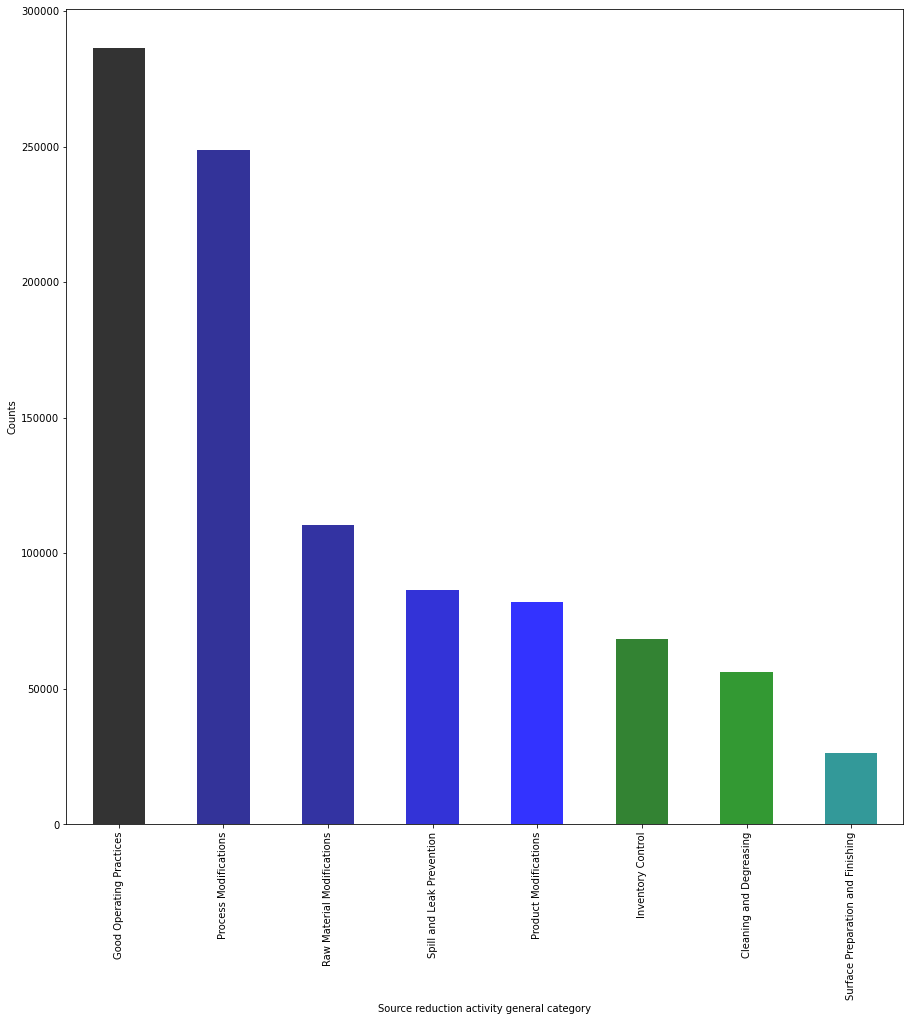

In [32]:
colors = list(mcolors.CSS4_COLORS.values())
colors.sort()
df['source_reduction_general_category'].value_counts().plot(kind='bar',
                                                alpha=0.8,
                                                figsize=(15, 15),
                                                color=colors[0:8])
plt.ylabel('Counts')
plt.xlabel('Source reduction activity general category')
plt.show()

As the figure above shows, the use of the 8 general categories for source reduction activities not only reduces the complexity of the classification task, but it could also reduce the imbalance of the dataset for those categories that previously did not even exceed 2000 samples.

## 4. Multivariate feature analysis

In [33]:
df['times'] = 1

### 4.1. Industry sectors V.S. source reduction

In [34]:
pivottable1 = pd.pivot_table(df, values='times', index=['2_digit_naics'],
               columns=['source_reduction_general_category'],
               aggfunc=np.sum, fill_value=0, margins=True)
pivottable1.sort_values(by='All', inplace=True, axis=0)
pivottable1.sort_values(by='All', inplace=True, axis=1)
pivottable1

source_reduction_general_category,Surface Preparation and Finishing,Cleaning and Degreasing,Inventory Control,Product Modifications,Spill and Leak Prevention,Raw Material Modifications,Process Modifications,Good Operating Practices,All
2_digit_naics,,,,,,,,,
Health Care and Social Assistance,0,0,0,0,0,0,0,197,197
Information,0,0,0,0,0,0,0,197,197
Other Services (except Public Administration),0,0,0,0,0,0,0,197,197
Transportation and Warehousing,0,0,0,197,0,0,0,0,197
"Agriculture, Forestry, Fishing and Hunting (not covered in economic census)",0,0,0,0,0,0,197,197,394
Educational Services,0,0,394,0,0,197,197,0,788
Administrative and Support and Waste Management and Remediation Services,0,0,394,197,0,394,394,591,1970
"Mining, Quarrying, and Oil and Gas Extraction",0,0,197,0,394,0,1182,394,2167
"Professional, Scientific, and Technical Services",0,0,591,0,197,0,197,1182,2167


The Pivot Table shows that the Manufacturing industry sector uses source reduction activities belonging to the 8 broad categories, even nearly all the records come from this sector (935,750 samples). As shown before, the dataset is umbalanced favoring activities in the Good Operating Practices, the same accurs for the Manufacturing industry sector. The tables also presents that there are sectors that only reported the implementation of only one source reduction activity category (e.g., Transportation and Warehousing only uses Product Modifications).

### 4.2 Industry sectors V.S. chemical categories (metallic, carginogen, and Clean Air Act)

In [35]:
pivottable2 = pd.pivot_table(df, values='times', index=['2_digit_naics'],
               columns=['caac_ind', 'carc_ind', 'metal_ind'],
               aggfunc=np.sum, fill_value=0, margins=True)
pivottable2.sort_values(by='All', inplace=True, axis=0)
pivottable2.sort_values(by='All', inplace=True, axis=1)
pivottable2

caac_ind                                              YES            NO  \
carc_ind                                              YES     NO     NO   
metal_ind                                             YES    YES    YES   
2_digit_naics                                                             
Health Care and Social Assistance                       5      6     10   
Information                                             5      6     10   
Other Services (except Public Administration)           5      6     10   
Transportation and Warehousing                          5      6     10   
Agriculture, Forestry, Fishing and Hunting (not...     10     12     20   
Educational Services                                   20     24     40   
Administrative and Support and Waste Management...     50     60    100   
Mining, Quarrying, and Oil and Gas Extraction          55     66    110   
Professional, Scientific, and Technical Services       55     66    110   
Utilities                                             135    162    270   
Public Administration (not covered in economic ...    185    222    370   
Wholesale Trade                                       220    264    440   
Manufacturing                                       23750  28500  47500   
All                                                 24500  29400  49000   

caac_ind                                                      YES          \
carc_ind                                              YES     YES      NO   
metal_ind                                              NO      NO      NO   
2_digit_naics                                                               
Health Care and Social Assistance                      13      41      49   
Information                                            13      41      49   
Other Services (except Public Administration)          13      41      49   
Transportation and Warehousing                         13      41      49   
Agriculture, Forestry, Fishing and Hunting (not...     26      82      98   
Educational Services                                   52     164     196   
Administrative and Support and Waste Management...    130     410     490   
Mining, Quarrying, and Oil and Gas Extraction         143     451     539   
Professional, Scientific, and Technical Services      143     451     539   
Utilities                                             351    1107    1323   
Public Administration (not covered in economic ...    481    1517    1813   
Wholesale Trade                                       572    1804    2156   
Manufacturing                                       61750  194750  232750   
All                                                 63700  200900  240100   

caac_ind                                                NO     All  
carc_ind                                                NO          
metal_ind                                               NO          
2_digit_naics                                                       
Health Care and Social Assistance                       73     197  
Information                                             73     197  
Other Services (except Public Administration)           73     197  
Transportation and Warehousing                          73     197  
Agriculture, Forestry, Fishing and Hunting (not...     146     394  
Educational Services                                   292     788  
Administrative and Support and Waste Management...     730    1970  
Mining, Quarrying, and Oil and Gas Extraction          803    2167  
Professional, Scientific, and Technical Services       803    2167  
Utilities                                             1971    5319  
Public Administration (not covered in economic ...    2701    7289  
Wholesale Trade                                       3212    8668  
Manufacturing                                       346750  935750  
All                                                 357700  965300

As shwon the above table, most of the records (346,750) reported by the sector are for chemicals non carcinogenic, non metallic, and non Clean Air Act chemicals and few samples (23,750) for chemicals beloging to the three categories. The good part is that all the industry sector reported source reduction activities for chemicals belonging to any of the 7 combinations presented in the table (i.e., in the columns).

### 4.3. Source reduction V.S. chemical categories (metallic, carginogen, and Clean Air Act)

#### 4.3.1. Source reduction V.S. carcinogen

In [36]:
df_carc = df.loc[df['carc_ind'] == 'YES', ['source_reduction_general_category', 'description_code', 'times']]
df_carc.reset_index(drop=True, inplace=True)
df_carc = df_carc.groupby(['source_reduction_general_category', 'description_code']).sum()
df_carc.sort_index(ascending=False, inplace=True)

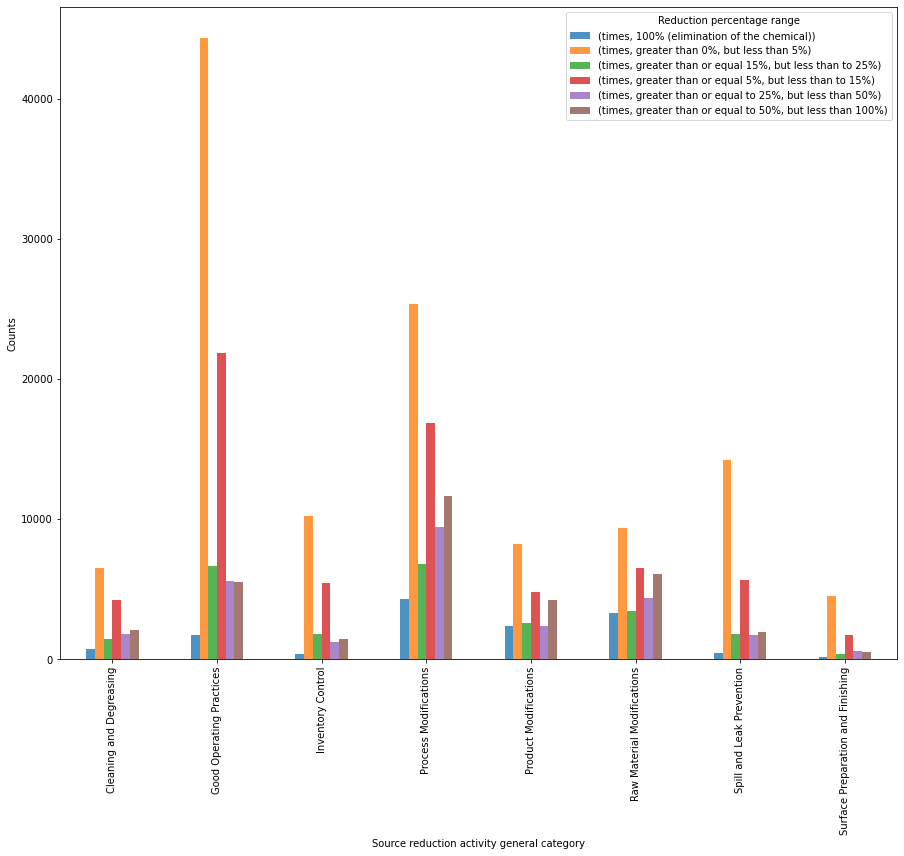

In [37]:
df_carc.unstack().plot(kind='bar', figsize=(15, 12), alpha=0.8)
plt.ylabel('Counts')
plt.xlabel('Source reduction activity general category')
plt.legend(title="Reduction percentage range");
plt.show()

#### 4.3.2. Source reduction V.S. metallic

In [38]:
df_metal = df.loc[df['metal_ind'] == 'YES', ['source_reduction_general_category', 'description_code', 'times']]
df_metal.reset_index(drop=True, inplace=True)
df_metal = df_metal.groupby(['source_reduction_general_category', 'description_code']).sum()
df_metal.sort_index(ascending=False, inplace=True)

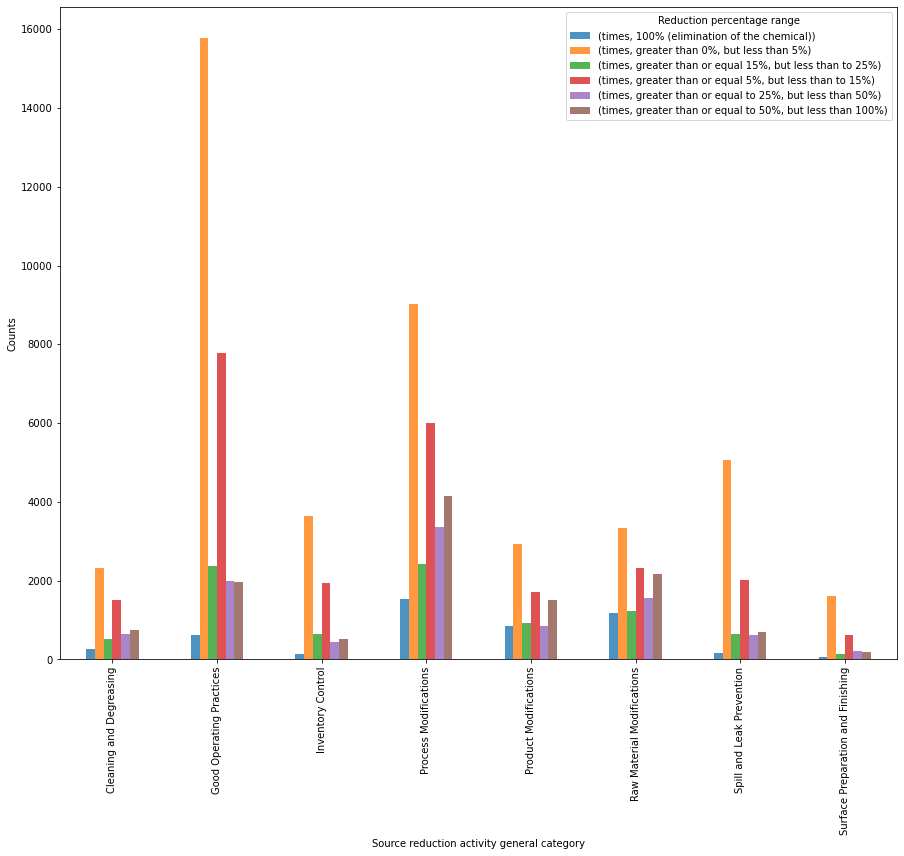

In [39]:
df_metal.unstack().plot(kind='bar', figsize=(15, 12), alpha=0.8)
plt.ylabel('Counts')
plt.xlabel('Source reduction activity general category')
plt.legend(title="Reduction percentage range");
plt.show()

#### 4.3.3. Source reduction V.S. Clean Air Act

In [40]:
df_caac = df.loc[df['caac_ind'] == 'YES', ['source_reduction_general_category', 'description_code', 'times']]
df_caac.reset_index(drop=True, inplace=True)
df_caac = df_caac.groupby(['source_reduction_general_category', 'description_code']).sum()
df_caac.sort_index(ascending=False, inplace=True)

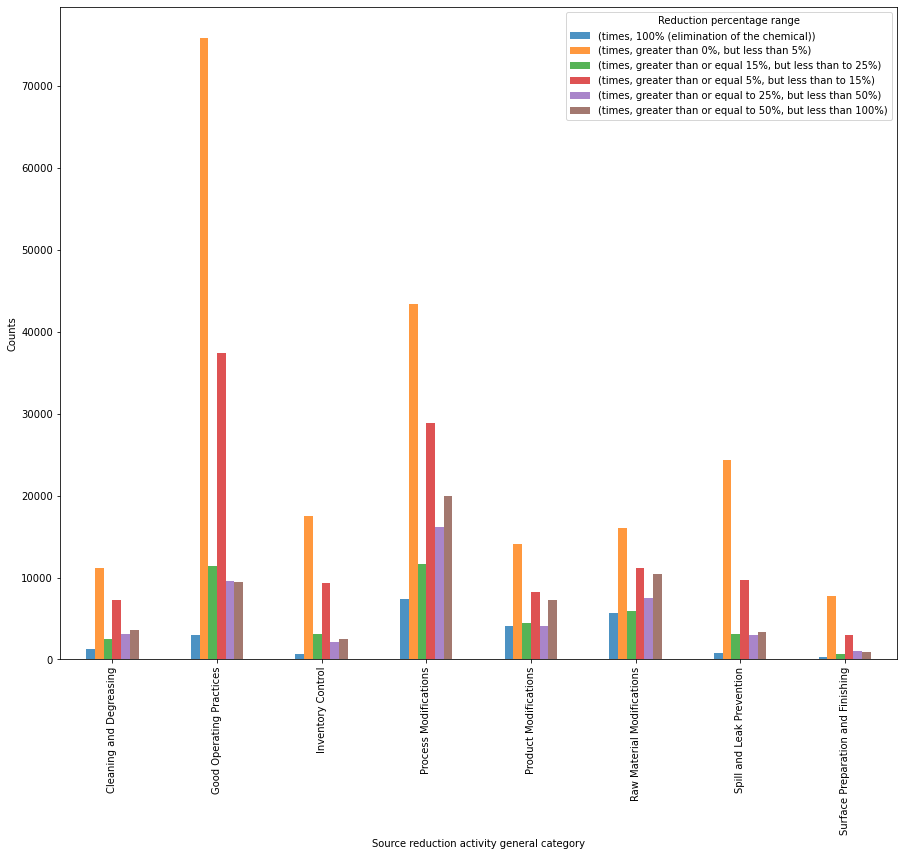

In [41]:
df_caac.unstack().plot(kind='bar', figsize=(15, 12), alpha=0.8)
plt.ylabel('Counts')
plt.xlabel('Source reduction activity general category')
plt.legend(title="Reduction percentage range");
plt.show()

The three figures above show that, although Good Operating Practices are the most likely type of source reduction activities, Process Modification is the source reduction activity that would most likely achieve complete elimination of carcinogenic, metallic or Clean Air Act chemicals. Additionally, in all scenarios, a pollutant reduction of as little as 0-5% or 5-15% would be more likely to be achieved.

## 5. Saving the useful features

In [48]:
df = df[['source_reduction_general_category', 'description_code', '2_digit_naics', 'smiles', 'cas_number', 'reporting_year']]
df.to_csv(os.path.join(os.getcwd(),
                        os.pardir,
                        'data',
                        'transformed',
                        'dataset_after_eda.csv'),
          index=False)

## 6. Conclusions

1. The EDA has shown that there is a relationship between the industrial sector and the potential type of source reduction activities that will be used to manage a pollutant. In addition, there is a relationship between industry sector and the type of chemical of concern for which the industry sector is willing to undertake a source reduction activity. This conclusion makes sense because hazardous chemicals are subject to special regulatory restrictions to protect human health and the environment. In addition, a chemical is subject to different activities depending on the industrial sector, which limits the possible source reduction activities that an industrial sector could use.
2. To use the underlying chemical information it would be necessary to use chemical descriptors, which would be easy using SMILES in the dataset.
3.  A data augmentation technique should be used to balance the categories and avoid potential bias and misclassification for source reduction categories, such as surface preparation and finishing, which are rare.